In [1]:
# 解析数据集中的二进制用的
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def decode_labels(file):
    '''
    解码标签文件
    '''
    
    # rb  ->  read binary
    with open(file, "rb") as f:
        binary_data = f.read()
        
    # 大端方式解析出2个int32，返回的是tuple(int1, int2)
    # int1 -> magic number，用来验证数据是否是目标数据
    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int32)

def decode_images(file):
    '''
    解码图像数据
    '''
    
    # rb  ->  read binary
    with open(file, "rb") as f:
        binary_data = f.read()
        
    # 大端方式解析出4个int32，返回的是tuple(magic number, num images, rows, cols)
    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * num_images * rows * cols, binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)

In [4]:
test_labels = decode_labels("dataset/t10k-labels-idx1-ubyte")
test_images = decode_images("dataset/t10k-images-idx3-ubyte")
train_labels = decode_labels("dataset/train-labels-idx1-ubyte")
train_images = decode_images("dataset/train-images-idx3-ubyte")

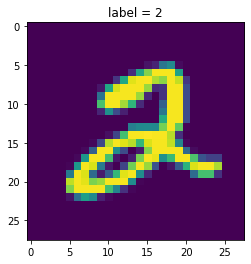

In [5]:
plt.imshow(train_images[5].reshape(28, 28))
_ = plt.title(f"label = {train_labels[5][0]}")

# BP的实现1，直接实现，不做任何封装
1. 网络有2个Linear层
2. 隐层节点数256
3. 使用Softmax Cross Entropy Loss
4. minbatch的大小设置为100
5. 学习率给0.1
6. 迭代轮数给10轮
7. 优化器，用SGD

In [6]:
# 初始化，超参数
np.random.seed(3)
num_train_images = train_images.shape[0]
num_feature   = train_images.shape[1]
num_hidden    = 256
num_classes   = 10
batch_size    = 100
learning_rate = 0.1
epochs        = 10

# 策略1，丢掉不足一个batch的数据，反正下次还可以看到它
# 策略2，不足一个batch的数据，依旧训练
num_batch_per_epoch = num_train_images // batch_size

# 初始化参数
# 行是输入维度，列是输出维度，对于bias来讲，输入恒等于1，所以维度是1x输出
layer1_weight = np.random.normal(0, 1 / np.sqrt(num_feature), size=(num_feature, num_hidden))
layer1_bias   = np.zeros((1, num_hidden))

layer2_weight = np.random.normal(0, 1 / np.sqrt(num_hidden), size=(num_hidden, num_classes))
layer2_bias   = np.zeros((1, num_classes))


# 定义数据相关的操作，以及索引
train_images_index = list(range(num_train_images))


# 定义sigmoid函数实现
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    ex = np.exp(x)
    return ex / ex.sum(axis=1, keepdims=True)


for epoch_index in range(epochs):
    
    # 每个epoch打乱索引
    np.random.shuffle(train_images_index)

    for batch_index in range(num_batch_per_epoch):
        
        # 取一个批次的索引
        batch_begin = batch_index * batch_size
        batch_end = min(batch_begin + batch_size, num_train_images)
        batch_images_index = train_images_index[batch_begin:batch_end]
        
        # 按照索引batch_images_index，取对应的一个批次的图像
        batch_images = train_images[batch_images_index]
        batch_labels = train_labels[batch_images_index]
        
        # 数据预处理
        batch_images = (batch_images / 255 - 0.5).astype(np.float32)
        
        # label变换为onehot
        batch_onehot_labels = np.zeros((batch_size, num_classes))
        for row, col in enumerate(batch_labels):
            batch_onehot_labels[row, col] = 1
        
        # 推理呀
        hidden = batch_images @ layer1_weight + layer1_bias
        hidden_activation = sigmoid(hidden)
        output = hidden_activation @ layer2_weight + layer2_bias
        
        # Softmax Cross Entropy Loss计算
        probability = softmax(output)
        loss = -np.sum(batch_onehot_labels * np.log(probability)) / batch_size
        
        # 反向求导
        # L对output求导
        # deltaB = A.T @ G
        # deltaA = G @ B.T
        delta_output            = (probability - batch_onehot_labels) / batch_size
        delta_layer2_bias       = np.sum(delta_output, axis=0)
        delta_layer2_weight     = hidden_activation.T @ delta_output
        delta_hidden_activation = delta_output @ layer2_weight.T
        delta_hidden            = delta_hidden_activation * sigmoid(hidden) * (1 - sigmoid(hidden))
        delta_layer1_bias       = np.sum(delta_hidden, axis=0)
        delta_layer1_weight     = batch_images.T @ delta_hidden
        
        # SGD优化器，更新参数
        layer2_bias             -= learning_rate * delta_layer2_bias
        layer2_weight           -= learning_rate * delta_layer2_weight
        layer1_bias             -= learning_rate * delta_layer1_bias
        layer1_weight           -= learning_rate * delta_layer1_weight
        
    norm_test_images  = (test_images / 255 - 0.5).astype(np.float32)
    hidden            = norm_test_images @ layer1_weight + layer1_bias
    hidden_activation = sigmoid(hidden)
    output            = hidden_activation @ layer2_weight + layer2_bias
    probability       = softmax(output)
    predict_label     = probability.argmax(axis=1).reshape(-1, 1)
    accuracy          = (predict_label == test_labels).sum() / test_labels.shape[0]
    print(f"{epoch_index}. Loss: {loss:.3f}, Accuracy: {accuracy:.5f}")

0. Loss: 0.472, Accuracy: 0.87380
1. Loss: 0.363, Accuracy: 0.90050
2. Loss: 0.331, Accuracy: 0.90650
3. Loss: 0.330, Accuracy: 0.91230
4. Loss: 0.244, Accuracy: 0.91210
5. Loss: 0.270, Accuracy: 0.91910
6. Loss: 0.319, Accuracy: 0.91980
7. Loss: 0.183, Accuracy: 0.92110
8. Loss: 0.249, Accuracy: 0.92500
9. Loss: 0.174, Accuracy: 0.92720


In [6]:
norm_test_images  = (test_images / 255 - 0.5).astype(np.float32)
hidden            = norm_test_images @ layer1_weight + layer1_bias
hidden_activation = sigmoid(hidden)
output            = hidden_activation @ layer2_weight + layer2_bias
probability       = softmax(output)
predict_label     = probability.argmax(axis=1).reshape(-1, 1)
accuracy          = (predict_label == test_labels).sum() / test_labels.shape[0]
accuracy

0.9272

# 考虑
1. 数据模块的封装，更加通用化
    - 目前有这么个任务，如何划分为不同人负责不同事。有几个角色？每角色的工作边界是怎样？相互之间如何协作？划分粒度如何考虑？如果规定工作流程，使得该流程能够在任意复杂的数据集上稳定工作而不用变动？
        - 任务：
            - 给定数据集，将数据集进行解析、加载。在需要的时候，对数据进行封装，每次随机加载一个批次的数据和标签。对于数据进行标准化/归一化，对标签进行onehot编码
        - 角色：
            - 数据集：负责数据的解析、加载、标准化/归一化，onehot
            - 加载器：负责在需要的时候对数据封装，每次随机加载一个批次数据
    - 实现：
        - 数据集[动态]：负责数据的解析、加载、标准化/归一化，onehot
            - 每次有新的任务，就开发一个新的数据集角色
                - 因为每个新的任务通常数据集的解析方式、加载方式，标准化方式等都不太一样。因此针对不同任务动态开发即可
            - 提供数据集的获取接口，使用\_\_getitem\_\_
                - 通过该接口，根据索引获取一个数据。返回的数据中，包含了图像、标签等不限定个数
                - 同时商定好数据集提供的数据的0维度是batch维度，加载器根据0维度进行拼接
            - 提供数据集规模的接口，使用\_\_len\_\_
        - 加载器[静态]：负责在需要的时候对数据封装，每次随机加载一个批次数据
            - 数据的封装（打包为一个矩阵），随机处理方式（shuffle）可以固定下来，绝大部分任务的需求都能够满足
            - 重点，所有的数据均来自数据集角色传递过来。因此加载器不区分数据是什么，仅仅是对数据进行封装拼接
            - 对于任何新任务的处理，只需要实现特定数据集相关的解析、加载、标准化等操作。加载器不用改变
            - 通过 for images, labels in loader的方式，即可拿到每一个批次数据，并且是打乱的。使用者只需要考虑指定批次大小即可控制批次的数量
2. 关于计算的封装
    - 如何封装细节，使得计算得以模块化，如何划分角色？角色如何分工？，相互如何协作？每层的计算是多种可能，优化的方式也是大有不同，模型的结构需要具有足够的灵活度，由开发者控制结构
    - 任务：
        - 给定输入数据和标签，定义参数和模型结构（function set，或者说是计算图），将数据按照function set/计算图执行运算得到预测结果，并计算loss，然后反向计算偏导数，链式法则求参数的梯度。得到梯度后，根据优化策略或方法应用梯度到参数中实现更新。循环这个过程
            - 计算图的每个算子可以作为一个单位抽象
            - 计算图中的计算，可以看做是数据的流动。而数据又分为“数据”和“参数”两个部分。tensorflow就是tensor在计算图中流动
    - 图表示：
        - <img src="关于抽象.png" />
        - 对计算人物分派个“层”角色做，参数与计算合为一体
        - 整个模型，则可以表示为多个层以图的形式构建的结果。数据则根据图结构在中间进行扭转实现前向、反过来根据图结构链式求导得到参数导数
    - 角色：
        - 数据：一部分由加载器产生的一个批次数据，另一部分由计算图的算子产生的中间数据
        - 层：对于每个算子（计算为主）抽象为具有“输入”数据，具有“输出”数据，和具有“参数”的一个整体。负责完成计算工作
            - 计算包括了forward前向推理，和backward反向求导
        - 参数：负责计算图中需要使用的参数，以及每个参数都需要对应的梯度。参数与算子封装成一个整体，作为算子的属性存在
            - data储存参数，grad储存梯度
        - 模型：作为一个整体算子，负责完成整个数据从输入到输出的过程。模型可以定义内部的计算图结构，该结构由多个算子（层）组成。模型描述了不同算子之间的数据扭转
        - 优化器：对给定图结构（模型）中所有的参数，使用参数对应的梯度进行特定方式的更新。被称为优化方法
            - 我们其实知道，有了梯度，优化的方法有多种。不同方法具有不同效果
- 角色之间的互相关系
    - <img src="关于抽象后的相互关系.png" />